In [56]:
import lightgbm as lgbm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [57]:
df = pd.read_csv('./data/cisco_demand_files/cisco_demand_datapack.csv')

# Strip and lowercase columns

df.columns = [col.strip().lower().replace(' ', '_') for col in df.columns]

for col in df.columns:
    if col.startswith('fy'):
        yr = col[2:6]
        qr = col[-2:]
        df.rename(columns={col:pd.PeriodIndex([f'{yr}-{qr}'], freq='Q').end_time[0].date( )}, inplace=True)
        
df.head()

,cost_rank,product_name,plc,2021-12-31,2022-03-31,2022-06-30,2022-09-30,2022-12-31,2023-03-31,2023-06-30,2023-09-30,2023-12-31,2024-03-31,2024-06-30,2024-09-30,demand_planners_forecast_for_fy24_q4,marketing_teams_forecast_for_fy24_q4,statistical_and_ml_forecast_for_fy24_q4
0,1,POWER SUPPLY 1,Sustaining-Growth,194170.0,220386.0,204604.0,194538,185160,147284,136997,100623,128229,100456,93373,115327,155152.1878,166531.00000,126349
1,2,WIRELESS CONTROLLER,Sustaining,2423.0,2602.0,2341.0,1830,1567,1210,1659,1311,1397,1013,1340,1193,1314.0000,1381.00000,1388
2,3,TRANSCEIVER MODULE,Sustaining,61867.0,69619.0,50150.0,57536,55380,63431,72611,65341,73713,49769,94247,86345,90000.0000,103657.13000,86514
3,4,POWER SUPPLY 2,Sustaining,47009.0,35145.0,45978.0,34518,40605,26925,23635,17799,24098,16871,18119,21393,25218.5216,26995.27028,21889
4,5,SERVER 1,Decline,2155.0,4025.0,7941.0,5091,5198,4223,5403,5136,6140,4876,5733,4264,5200.0000,5035.00000,4899


In [58]:
# Separate forecast columns

forecasts = df[['cost_rank','plc','demand_planners_forecast_for_fy24_q4', 'marketing_teams_forecast_for_fy24_q4', 'statistical_and_ml_forecast_for_fy24_q4']]
#forecasts.head()

df = df.drop(columns={'cost_rank','plc','demand_planners_forecast_for_fy24_q4', 'marketing_teams_forecast_for_fy24_q4', 'statistical_and_ml_forecast_for_fy24_q4'})
df.columns

Index(['product_name',     2021-12-31,     2022-03-31,     2022-06-30,
           2022-09-30,     2022-12-31,     2023-03-31,     2023-06-30,
           2023-09-30,     2023-12-31,     2024-03-31,     2024-06-30,
           2024-09-30],
      dtype='object')

In [59]:
# Stack data

df_stacked = df.set_index(["product_name"]).stack()
df_stacked

product_name              
POWER SUPPLY 1  2021-12-31    194170.0
                2022-03-31    220386.0
                2022-06-30    204604.0
                2022-09-30    194538.0
                2022-12-31    185160.0
                                ...   
SERVER 3        2023-09-30      2764.0
                2023-12-31      3682.0
                2024-03-31      2744.0
                2024-06-30      1952.0
                2024-09-30      2176.0
Length: 237, dtype: float64

In [60]:
# Transposing dataframe

df = df.transpose()
df.columns = df.iloc[0]
df = df[1:]

df.columns.name = None
df['date'] = df.index
df = df[['date', *df.columns[:-1]]]
df.reset_index(drop=True, inplace=True)

# Fixing dtypes
df['date'] = pd.to_datetime(df['date'])
for col in df.columns[1:]:
    df[col] = pd.to_numeric(df[col])
    
df

,date,POWER SUPPLY 1,WIRELESS CONTROLLER,TRANSCEIVER MODULE,POWER SUPPLY 2,SERVER 1,SWITCH 1,SWITCH 2,ACCESS POINT,ROUTER 1,...,ROUTER 3,SWITCH 3,ROUTER 4,PHONE 1,PHONE 2,SWITCH 4,SWITCH 5,SERVER 2,ROUTER 5,SERVER 3
0,2021-12-31,194170.0,2423.0,61867.0,47009.0,2155.0,779.0,726.0,16031.0,5146.0,...,NaN,8234.0,8154.0,22204.0,14175.0,196.0,1042.0,380.0,39.0,5882.0
1,2022-03-31,220386.0,2602.0,69619.0,35145.0,4025.0,712.0,1279.0,11660.0,5938.0,...,NaN,9924.0,11367.0,39146.0,12356.0,287.0,1045.0,498.0,4.0,4442.0
2,2022-06-30,204604.0,2341.0,50150.0,45978.0,7941.0,815.0,2107.0,12112.0,6025.0,...,NaN,18032.0,8071.0,13657.0,13605.0,319.0,1279.0,900.0,116.0,6272.0
3,2022-09-30,194538.0,1830.0,57536.0,34518.0,5091.0,698.0,2027.0,11593.0,8704.0,...,9.0,9628.0,10442.0,28994.0,8069.0,74.0,1206.0,563.0,6.0,3624.0
4,2022-12-31,185160.0,1567.0,55380.0,40605.0,5198.0,980.0,1851.0,21120.0,4912.0,...,83.0,7697.0,10504.0,25408.0,7726.0,120.0,970.0,889.0,101.0,5694.0
5,2023-03-31,147284.0,1210.0,63431.0,26925.0,4223.0,832.0,1947.0,9375.0,3978.0,...,126.0,4242.0,4386.0,16556.0,5197.0,14.0,1146.0,643.0,46.0,3090.0
6,2023-06-30,136997.0,1659.0,72611.0,23635.0,5403.0,496.0,1979.0,16406.0,4428.0,...,223.0,6383.0,4456.0,16653.0,5124.0,127.0,731.0,1089.0,17.0,3622.0
7,2023-09-30,100623.0,1311.0,65341.0,17799.0,5136.0,384.0,1986.0,11071.0,2958.0,...,241.0,3382.0,10418.0,16970.0,3486.0,195.0,498.0,1280.0,40.0,2764.0
8,2023-12-31,128229.0,1397.0,73713.0,24098.0,6140.0,528.0,2422.0,9333.0,4230.0,...,286.0,1716.0,11105.0,19802.0,4128.0,175.0,1318.0,725.0,47.0,3682.0
9,2024-03-31,100456.0,1013.0,49769.0,16871.0,4876.0,471.0,2269.0,8043.0,2225.0,...,195.0,2516.0,2899.0,16305.0,5786.0,147.0,544.0,977.0,60.0,2744.0


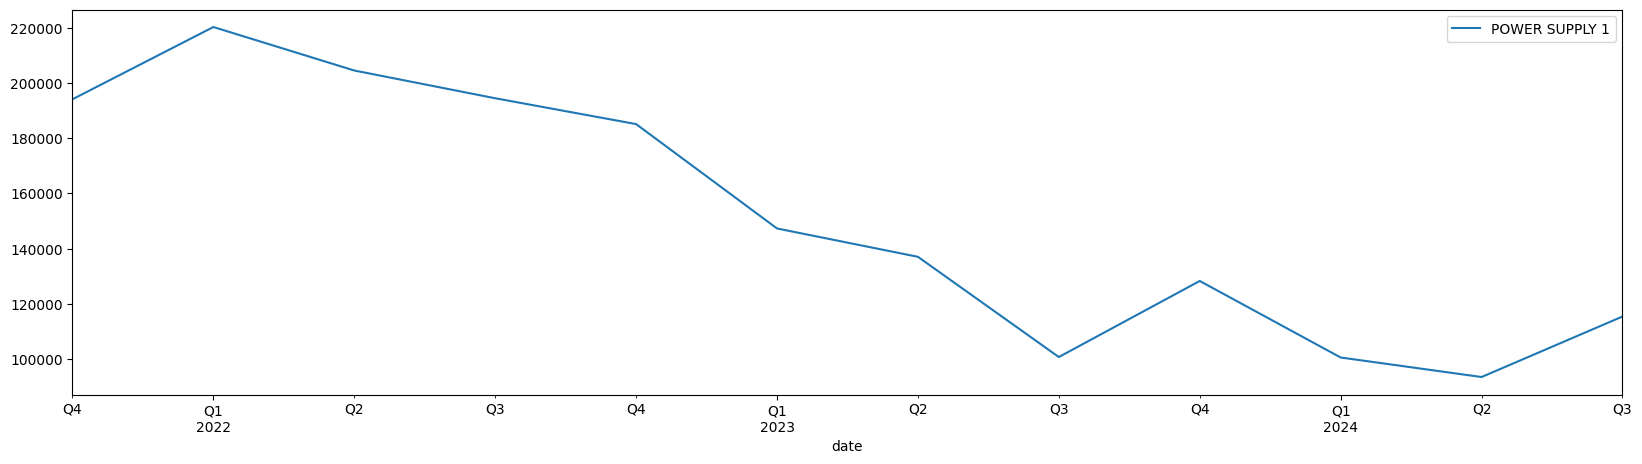

In [61]:
# Plotting demand

fig, ax = plt.subplots(figsize=(20, 5))

#for col in df.columns:
#    df[col].plot(ax=ax, label=col)

df.plot(ax=ax, x='date', y='POWER SUPPLY 1')
    
plt.show()

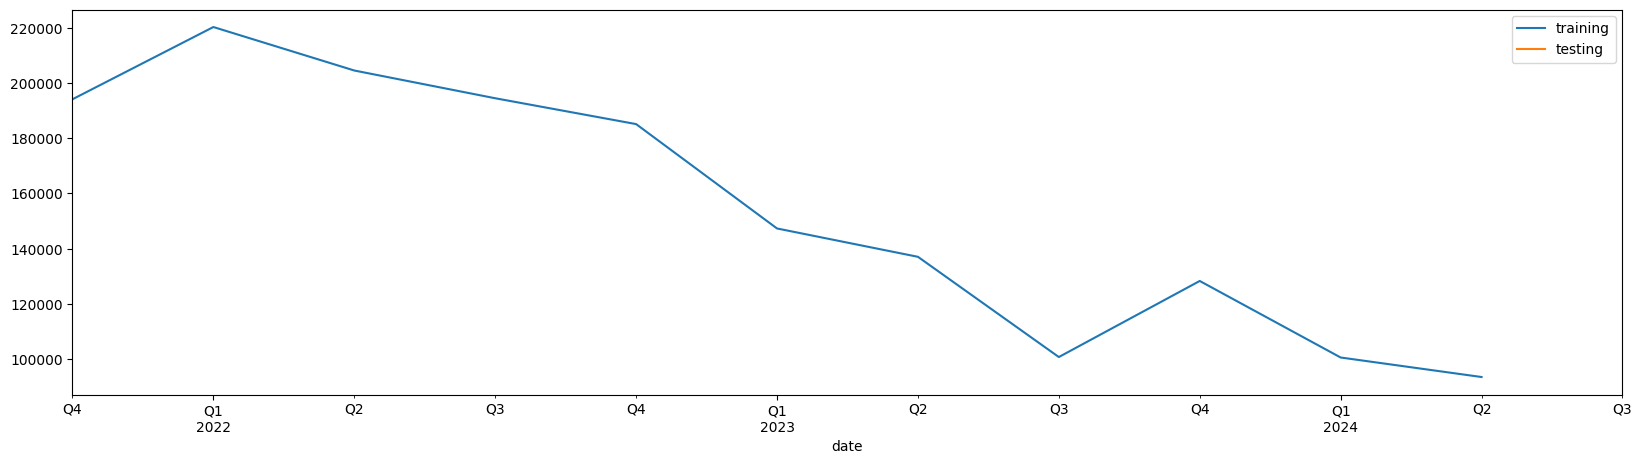

In [62]:
df_training = df.loc[df['date'] < '2024-09-30']
df_testing = df.loc[df['date'] >= '2024-09-30']

# Plotting

fig, ax = plt.subplots(figsize=(20, 5))

df_training.plot(ax=ax, x='date', y='POWER SUPPLY 1', label='training')
df_testing.plot(ax=ax, x='date', y='POWER SUPPLY 1', label='testing')

plt.show()

In [63]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train = df_training['date']
y_train = df_training['POWER SUPPLY 1']

X_test = df_testing['date']
y_test = df_testing['POWER SUPPLY 1']

# Feature engineering: Convert 'date' to a numeric feature (e.g., time elapsed)
df['quarter'] = np.arange(1, len(df)+1)

# Define features (e.g., 'quarter') and target variable ('POWER SUPPLY 1')
X = df[['quarter']]  # Add more features if necessary
y = df['POWER SUPPLY 1']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train the LightGBM model
lgb_train = lgbm.Dataset(X_train, y_train)
lgb_test = lgbm.Dataset(X_test, y_test, reference=lgb_train)

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'max_depth': -1,
    'verbose': -1
}

# Train the model
model = lgbm.train(params, lgb_train, num_boost_round=100, valid_sets=lgb_test)

# Make predictions
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

<Axes: >

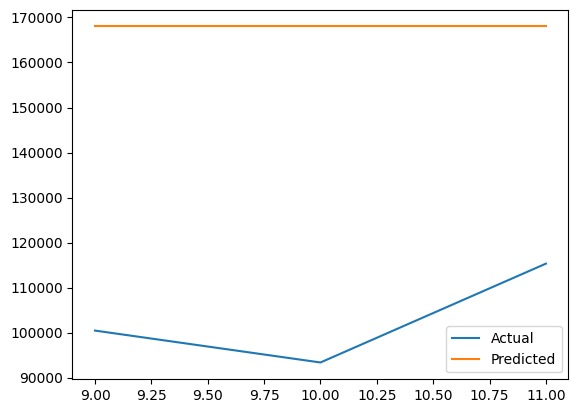

In [65]:
# View the predicted values alongside actual values
predictions = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})

predictions.plot()